In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
from scipy import stats
import pickle
from collections import Counter

from scipy.stats import kurtosis, skew, spearmanr, pearsonr


#modelling
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plot
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from UTILS import perc_element_dico
import config_mobility as config

c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
#comment on this run of the script
comment = ''

### choose hybrid type
type_hybrid = 'LB' #LSL, all, LB

### choose type of word definition
type_ = 'fixedLength' ; length_words = 3 ; comment = comment+'lengthwords_'+str(length_words)
#type_ = 'varyinglength' ; morethan4_in1 = True ; comment = comment+'morethan4in1_'+str(int(morethan4_in1))

### choose session to take into account
li_sess = [[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[8,9,10],[9,10,11]]
li_sess = [[1,2,3,4],[2,3,4,5],[3,4,5,6],[4,5,6,7],[5,6,7,8],[6,7,8,9],[7,8,9,10],[8,9,10,11]]

In [4]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run

## Data at KBF level

In [5]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';', parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
#dico or join by hen (not day as some are nan but we actually know then)
df_master['day'] = df_master['day'].map(lambda x: dt.datetime.strptime(x, "%d.%m.%Y"))
df_master['HenID'] = df_master['HenID'].map(str)
dico_hen_group = dict(zip(df_master['HenID'].tolist(), df_master['group'].tolist()))
df_master['HenID'] = df_master['HenID'].map(lambda x: 'hen_'+str(x))
#df_master.filter(['HenID','group'])
print(df_master.shape)
df_master.head(3)

(7920, 43)


,HenID,timepoint,group,age,DayID,day,file,severity,pen,hybrid,...,meanchange,mean1,medianchange,transitions,real0,sumdur,nest_vs_total,severity_diff,KBF_new,indicator
0,hen_1,1,A,21,1,2016-10-27,1A01,0.0,1,LSL,...,1.23,1.0,1.0,91.0,NaN,57067.0,0.177419,NaN,0.0,NaN
1,hen_1,1,A,21,2,2016-10-28,1A01,0.0,1,LSL,...,1.28,1.0,1.0,108.0,NaN,56854.0,0.171053,0.0,0.0,NaN
2,hen_1,1,A,21,3,2016-10-29,1A01,0.0,1,LSL,...,1.17,1.0,1.0,128.0,NaN,56721.0,0.255319,0.0,0.0,NaN


0.0    373
1.0    332
Name: gap, dtype: int64

c:\users\camil\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
c:\users\camil\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


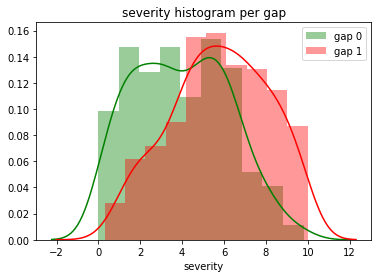

In [8]:
#gap variable
df_ = df_master[['gap','severity','timepoint']].drop_duplicates(subset=None, keep='first', inplace=False)
display(df_['gap'].value_counts())
df_[df_['gap']==0]['severity']
sns.distplot( df_[df_['gap']==0]['severity'], color="green", label="gap 0")
sns.distplot( df_[df_['gap']==1]['severity'], color="red", label="gap 1")
plt.legend();
plt.title('severity histogram per gap')
plt.savefig(os.path.join(path_extracted_data, 'visual', 'severity histogram per gap.png'),dpi=300,bbox_inches='tight')
plt.show()

In [9]:
#create dico to match each day to the session and number of days of the session
df_ = df_master.groupby('timepoint')['day'].agg(lambda x: sorted(set(x))).reset_index()
dico_day_sessiontpt = {}
for tpt in df_master['timepoint'].unique():
    li_d = df_[df_['timepoint']==tpt]['day'].values[0]
    for i,d in enumerate(li_d):
        dico_day_sessiontpt[d] = 'sess_'+str(tpt)+'_day'+str(i%6) #modulo 6 to take into account groups A and B
#dico_day_sessiontpt

In [10]:
df_kbf = df_master[['HenID','severity','gap','timepoint','hybrid']].copy()
df_kbf = df_kbf.drop_duplicates(subset=None, keep='first', inplace=False)
print(df_kbf.shape)
df_kbf.head(3)

(1320, 5)


,HenID,severity,gap,timepoint,hybrid
0,hen_1,0.0,0.0,1,LSL
6,hen_1,0.0,0.0,2,LSL
12,hen_1,0.8,0.0,3,LSL


In [11]:
#dico to match henID to hybrid
dico_henid_hybrid = dict(zip(df_kbf['HenID'].tolist(),df_kbf['hybrid'].tolist()))
li_LB = df_master[df_master['hybrid']=='LB']['HenID'].unique()
li_LSL = df_master[df_master['hybrid']=='LSL']['HenID'].unique()
print(len(li_LB), len(li_LSL))
li_LB[0:2]

60 60


array(['hen_41', 'hen_42'], dtype=object)

## Rest

In [12]:
li_mlp = ['FirstTimestamp_zone_1_h','FirstTimestamp_zone_2_h','FirstTimestamp_zone_3_h',
          'FirstTimestamp_zone_4_h','FirstTimestamp_zone_5_h','Max_duration_zone_4',
          'median_duration','min_duration','mean_duration','max_duration','variance_duration',
          'SampEnt_order2',
          'Total_number_transition','Total_number_zone','distribution_entropy','duration_zone_1',
          'duration_zone_3','duration_zone_4','duration_zone_5','nbr_bouts_zone_1',
          'nbr_bouts_zone_3','nbr_bouts_zone_4','nbr_bouts_zone_5',
          'down_missingZone_mvtPerc','up_missingZone_mvtPerc','down_missingZone_mvtNbr','up_missingZone_mvtNbr',
          'chatoicmvt_Middlezone_1_nbr','chatoicmvt_Middlezone_2_nbr','chatoicmvt_Middlezone_3_nbr',
          'chatoicmvt_Middlezone_4_nbr', 'chatoicmvt_Middlezone_5_nbr',
          'percentile_5','percentile_15','percentile_85','percentile_95']

In [13]:
#plt.hist(df_mlp['Total_number_transition'].tolist(), bins=300);

In [12]:
for Sess2keep in li_sess:

    ### unique naming
    title_ = type_hybrid+'---'+type_+'---'+comment+'---sess_'+'_'.join([str(x) for x in Sess2keep]) 
    #'_LB', '_all','_LSL' '_LB_newword_def' '_all_newword_def'
    print('The topic modeling used is named: '+title_)
    path_save_ = os.path.join(path_extracted_data, 'visual', 'predict_KBF', title_)
    #create a director if not existinga
    if not os.path.exists(path_save_):
        os.makedirs(path_save_)
    
    ################## Data at day level
    ### topic modelling (all k into one dataframe)
    li_dflda = []
    min_topic = 2
    li_path = glob.glob(os.path.join(path_extracted_data,'visual','TM', title_, '*'))
    max_topic = max([int(x.split('\\')[-1]) for x in li_path if x.split('\\')[-1].isdigit()])
    df_all_lda = pd.DataFrame(columns=['day','HenID'])
    for nbr_topics_ in range(min_topic,max_topic+1):
        #print(df_all_lda.shape)
        path_save = os.path.join(path_extracted_data,'visual','TM', title_, str(nbr_topics_))
        df_lda = pd.read_csv(os.path.join(path_save,'df_topics'+str(nbr_topics_)+'.csv'), sep=';',parse_dates=['day']) 
        #print(df_lda.shape)
        #df_lda.head(3)
        df_lda['topic'] = df_lda['topic'].map(lambda x: 'topic_'+str(x))
        #lets take the topic distribution / main topic of the clustering with k=6-15 over all the days of the first session
        li_sorted_days = df_lda.sort_values(['day'],ascending=True)['day'].unique()
        li_topics = [x for x in df_lda.columns if (x.startswith('topic')) & (x!='topic_info')]
        dico_topics_newtopics = {c:'k'+str(nbr_topics_)+'_'+ c for c in li_topics}
        df_lda.rename(columns=dico_topics_newtopics, inplace=True)
        df_all_lda = pd.merge(df_all_lda, df_lda[['HenID','day']+list(dico_topics_newtopics.values())], on=['HenID','day'], 
                              how='outer')
    #print(df_all_lda.shape)
    df_all_lda.head(3)

    ### MLPS session metrics
    li_path = glob.glob(os.path.join(path_extracted_data,'VF_time_serie_day_*_variables.csv')) #_SIMPLER
    li_zone = ['zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5']
    li_df = []
    for path_ in li_path:
        sessID = path_.split('_')[-2]
        df_ = pd.read_csv(path_, sep=';', parse_dates=['level','FirstTimestamp_zone_1','FirstTimestamp_zone_2',
                                                       'FirstTimestamp_zone_3','FirstTimestamp_zone_4','FirstTimestamp_zone_5'])
        #day 2017-08-07 egg quality must be linked to the MLPs variable of the day 2017-08-06 with possible bias induce by if the hen 
        #laid the egg at 9h on the 2017-08-06 (or anytime after 8h, the time where the people take the egg). 
        df_['egg_level'] = df_['level'].map(lambda x: x+dt.timedelta(days=1))
        #for z in li_zone:
        #    df_['SampEnt_'+z] = df_['SampEnt_perZone'].map(lambda x: eval(x).get(z,0))
        #    df_['SampEnt_'+z] = df_['SampEnt_'+z].replace(-0.0,0)
        #df_.drop(columns=['verification_daily_total_duration','SampEnt_perZone'], inplace=True)    
        #put to have less change among the dependant variable entries
        df_['SampEnt_order2'] = df_['SampEnt_order2'].map(lambda x: x*10000)
        for v in ['duration_zone_1','duration_zone_2','duration_zone_3','duration_zone_4','duration_zone_5']:
            df_[v] = df_[v].map(lambda x: x/60/60)
        #df_['Variance_duration'] = df_['Variance_duration'].map(lambda x: x/(60*60)/(60*60))
        li_fts = ['FirstTimestamp_zone_1','FirstTimestamp_zone_2','FirstTimestamp_zone_3','FirstTimestamp_zone_4',
                  'FirstTimestamp_zone_5']
        for x in li_fts:
            df_[x+'_h'] = df_[x].map(lambda x: x.hour+x.minute/60+x.second/60/60)
            #lets say if we dont know that they went to 17h
            df_[x+'_h'].fillna(17, inplace=True)
        df_['session'] = sessID
        li_df.append(df_)
    df_mlp = pd.concat(li_df)
    #fill nan
    li = ['SampEnt_order2', 'SampEnt_zone_1','SampEnt_zone_2', 'SampEnt_zone_3', 'SampEnt_zone_4', 'SampEnt_zone_5',
          'RunSampEnt_onLastTsOfEachLevel', 'RunDistEnt_onLastTsOfEachLevel',
          'RunSampEnt_onLastTsOfEachLevel_1', 'RunSampEnt_onLastTsOfEachLevel_2',
          'RunSampEnt_onLastTsOfEachLevel_3', 'RunSampEnt_onLastTsOfEachLevel_4',
          'RunSampEnt_onLastTsOfEachLevel_5',
          'distribution_entropy']
    li = [x for x in li if x in df_mlp.columns]
    df_mlp[li] = df_mlp[li].fillna(0.0)
    #print(df_mlp.shape)
    #display(df_mlp.head(3))
    
    #keep columns of one species only if wanted
    #print(df_mlp.shape)
    if 'LB' in title_:
        df_mlp = df_mlp[df_mlp['HenID'].isin(li_LB)]
    if 'LSL' in title_:
        df_mlp = df_mlp[df_mlp['HenID'].isin(li_LSL)]
    #print(df_mlp.shape)
    #keep good sessions
    df_mlp['timepoint'] = df_mlp['session'].map(lambda x: int(x[:-1]))
    df_mlp = df_mlp[df_mlp['timepoint'].isin(Sess2keep)]

    ################### Egg quality level
    df_egg = pd.read_csv(os.path.join(path_initial_data,'Mo_eggs_matched_with_ID.csv'), sep=';', parse_dates=['Date'])
    #print(df_egg.shape)
    #df_egg = df_egg[df_egg['Strength']!='na']
    df_egg['Date']= df_egg['Date'].replace(dt.datetime(2017,9,15), dt.datetime(2017,8,15)) #TODO: ASK YAMENAH CORRECT?
    df_egg = df_egg.replace('na', np.nan)
    df_egg['Strength'] = df_egg['Strength'].astype(float)
    df_egg['Mass'] = df_egg['Mass'].astype(float)
    df_egg['Width'] = df_egg['Width'].astype(float)
    df_egg.rename(columns={'Date':'egg_level', 'HenID_Christina':'HenID'}, inplace=True)
    df_egg['HenID'] = df_egg['HenID'].map(lambda x: 'hen_'+str(x))
    df_egg['is_LSL'] = df_egg['hybrid'].map(lambda x: float(x=='LSL'))
    #print(df_egg[df_egg['Strength'].isnull()].shape, df_egg[df_egg['Mass'].isnull()].shape, df_egg[df_egg['Width'].isnull()].shape)
    #print(df_egg.shape)
    #display(df_egg.head(3))
    df_egg_summary = df_egg.groupby(['HenID']).agg({t: {'tuple':lambda x: tuple(x), 
                                                'nbr':lambda x: len(set(x)),
                                                'variance':lambda x: np.var(x),
                                                'mean':lambda x: np.mean(x)} for t in ['Strength','Mass','Width']}).reset_index()
    #print(df_egg_summary.shape)
    #display(df_egg_summary)

    ############# Aggregate for modelling
    ###### one row per hen
    #KBF
    df_hen = df_kbf.groupby('HenID')['severity','gap'].agg(lambda x: list(x)).reset_index()
    df_hen.rename(columns={'severity':'li_severity','gap':'li_gap'}, inplace=True)
    df_hen['nbr_nan'] = df_hen['li_severity'].map(lambda x: sum(math.isnan(i) for i in x))
    ##### gap var
    #df_hen['max_gap'] = df_hen['li_gap'].map(lambda x: max(x)) #only 1's
    #what was the severity when the gap went into 1? issue: 8,4 would mean: soit chicken had severity from 0 to 8,4 and hence a 
    #gap, soit le chicks had 0,2,4,5,6,8 severity and no gap during long time! Two different chicken!!
    #--> sum of severity with gap 0 (0: mean never gap while severity OR never severity and never gap). WE REMOVE THE SEVERITY=0
    df_hen['AvgSeverity_gap1'] = df_hen.apply(lambda x:np.mean(np.array(x['li_severity'])[np.array(x['li_gap'])==1]),axis=1)
    df_hen['AvgSeverity_gap0'] = df_hen.apply(lambda x:np.mean([i for i in np.array(x['li_severity'])[np.array(x['li_gap'])==0] if i!=0]),axis=1)
    #issue with this var:  if severity is ver low, and chick has gap0 during this time then the average severity during gap0 will be
    #lower, but actually it is still good to have gap 0 for low severity and long time!
    df_hen['AvgSeverity_gap1-AvgSeverity_gap0'] = df_hen['AvgSeverity_gap1']-df_hen['AvgSeverity_gap0']
    #this measure is better!!
    df_hen['maxsevGap0_divided_maxsev'] = df_hen.apply(lambda x: max(np.array(x['li_severity'])[np.array(x['li_gap'])==0])/max(np.array(x['li_severity'])), axis=1)
    ##### severity var
    df_hen['max_severity'] = df_hen['li_severity'].map(lambda x: max(x))
    df_hen['positive_rate_in_severity'] = df_hen['li_severity'].map(lambda x: [x[i+1]-x[i] for i in range(0,len(x)-1) if (x[i+1]>x[i]) & (len(x)>0)]+[0])
    df_hen['max_positive_rate_in_severity'] = df_hen['positive_rate_in_severity'].map(lambda x: max(x))
    #removing the hens that have more than 7 nan and the one that have more than 2 nan and a low severity (i.e. if a lot of 
    #nan but high severity then we can still keep it)
    #print(df_hen.shape)
    df_hen = df_hen[~((df_hen['nbr_nan']>7) | ((df_hen['max_severity']<5) & (df_hen['nbr_nan']>=2)))]
    #print(df_hen.shape)
    #variation without nan
    df_hen['li_severity_nonan'] = df_hen['li_severity'].map(lambda x: [i for i in x if not math.isnan(i)])
    df_hen['time_of_max_severity'] = df_hen['li_severity_nonan'].map(lambda x: x.index(max(x)))
    df_hen['var_severity'] = df_hen['li_severity_nonan'].map(lambda x: np.var([i for i in x if not math.isnan(i)]))
    #lets define the capacity of healing by the sum of the do (the closest is to one, the more healing there is. 1 would mean equal number of healing than 
    #non-healing, meaning ending at 0 KBF)
    df_hen['ratio_HealingAndNonhealing'] = df_hen['li_severity_nonan'].map(lambda x: sum([x[i]-x[i+1] for i in range(0,len(x)-1) if x[i+1]<x[i]])/\
                                                                                     sum([x[i+1]-x[i] for i in range(0,len(x)-1) if x[i+1]>x[i]]))
    df_hen['ratio_HealingAndNonhealing_round'] = df_hen['ratio_HealingAndNonhealing'].map(lambda x: round(x,1))
    dico_henid_healinratio = dict(zip(df_hen['HenID'].tolist(),df_hen['ratio_HealingAndNonhealing_round']))
    dico_henid_var = dict(zip(df_hen['HenID'].tolist(),df_hen['var_severity']))
    df_hen

    #egg quality info
    #print(df_hen.shape)
    df_hen = pd.merge(df_hen, df_egg_summary, on='HenID', how='left')
    #print(df_hen.shape)
    #display(df_hen)
    #save hen info
    df_hen['hybrid'] = df_hen['HenID'].map(lambda x: dico_henid_hybrid[x])
    df_hen.to_csv(os.path.join(path_extracted_data,'df_1row1hen_kbf&egg.csv'), index=False, sep=';')
    #keep columns of one species only if waned
    #print(df_hen.shape)
    if 'LB' in title_:
        df_hen = df_hen[df_hen['HenID'].isin(li_LB)]
    if 'LSL' in title_:
        df_hen = df_hen[df_hen['HenID'].isin(li_LSL)]
    #print(df_hen.shape)

    #### one row per hen per day
    #first merge all day level time series
    df_mlp.rename(columns={'level':'day'}, inplace=True)
    df_day = pd.merge(df_all_lda, df_mlp, on=['HenID', 'day'], how='outer')
    #df_day = pd.merge(df_day, df_IDS, on=['HenID', 'day'], how='left')
    #print(df_all_lda.shape, df_mlp.shape, df_day.shape)
    #add session id to match each day to an "age" independantly to the group (A or B)
    df_day['sessionid'] = df_day['day'].map(lambda x: dico_day_sessiontpt.get(x,np.nan))
    #df_day.head(3)

    ################ aggregate for modelling - one row per hen per day
    df_modelling = pd.merge(df_day, df_hen, on=['HenID'], how='left')
    #print(df_day.shape, df_hen.shape, df_modelling.shape)
    #display(df_modelling.head(3))

    ######### save
    #print(df_modelling.shape)
    df_modelling = df_modelling[~df_modelling['max_severity'].isnull()]
    #keep only the birds with at least 5 transition over the day
    df_modelling = df_modelling[df_modelling['Total_number_transition']>=5]
    df_modelling.to_csv(os.path.join(path_save_,'df_modelling.csv'), index=False, sep=';')
    print(df_modelling.shape)
    df_modelling.head(3)

The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_1_2_3_4


c:\users\camil\anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)
c:\users\camil\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\camil\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in double_scalars
c:\users\camil\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
c:\users\camil\anaconda3\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a

(1278, 222)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_2_3_4_5
(1278, 317)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_3_4_5_6
(1244, 317)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_4_5_6_7
(1216, 296)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_5_6_7_8
(1220, 317)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_6_7_8_9
(1171, 296)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_7_8_9_10
(1093, 96)
The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_8_9_10_11
(1019, 317)


In [13]:
df_mlp.columns

Index(['FirstTimestamp_zone_1', 'FirstTimestamp_zone_1_h',
       'FirstTimestamp_zone_2', 'FirstTimestamp_zone_2_h',
       'FirstTimestamp_zone_3', 'FirstTimestamp_zone_3_h',
       'FirstTimestamp_zone_4', 'FirstTimestamp_zone_4_h',
       'FirstTimestamp_zone_5', 'FirstTimestamp_zone_5_h', 'HenID',
       'Max_duration_zone_4', 'Max_duration_zones', 'SampEnt_order2',
       'Total_number_transition', 'Total_number_zone',
       'chatoicmvt_Middlezone_1', 'chatoicmvt_Middlezone_1_nbr',
       'chatoicmvt_Middlezone_2', 'chatoicmvt_Middlezone_2_nbr',
       'chatoicmvt_Middlezone_3', 'chatoicmvt_Middlezone_3_nbr',
       'chatoicmvt_Middlezone_4', 'chatoicmvt_Middlezone_4_nbr',
       'chatoicmvt_Middlezone_5', 'chatoicmvt_Middlezone_5_nbr',
       'dico_z_chaoticmvtMiddleDuration', 'dico_zone_sortedduration',
       'distribution_entropy', 'down_missingZone_mvtNbr',
       'down_missingZone_mvtPerc', 'dur_values', 'dur_values_normalized',
       'duration_zone_1', 'duration_zone_2',

In [14]:
df_mlp[['percentile_5', 'percentile_15', 'percentile_85','percentile_95', 'chatoicmvt_Middlezone_1_nbr',
        'chatoicmvt_Middlezone_2_nbr','chatoicmvt_Middlezone_3_nbr','chatoicmvt_Middlezone_4_nbr', 
        'chatoicmvt_Middlezone_5_nbr']].head(3)

,percentile_5,percentile_15,percentile_85,percentile_95,chatoicmvt_Middlezone_1_nbr,chatoicmvt_Middlezone_2_nbr,chatoicmvt_Middlezone_3_nbr,chatoicmvt_Middlezone_4_nbr,chatoicmvt_Middlezone_5_nbr
180,0.340000,0.4675,41.191667,76.807500,0,1,1,3,2
181,0.148333,0.7525,31.924167,58.425833,1,2,1,3,1
182,0.226667,0.5075,50.223333,81.794167,0,0,0,4,3


In [15]:
#print rows with at least 10 nan values
#df_modelling[df_modelling.isnull().sum(axis=1)>10]

In [117]:
df_hen = pd.read_csv(os.path.join(path_extracted_data,'df_1row1hen_kbf&egg.csv'), sep=';')
#can not do eval with nan in the list!
df_hen['li_severity_nonan'] = df_hen['li_severity_nonan'].map(lambda x: eval(x))
df_hen['time_of_max_severity'] = df_hen['li_severity_nonan'].map(lambda x: x.index(max(x)))
df_hen = df_hen[df_hen['hybrid']=='LB']
print(df_hen.shape)
df_hen.head(3)

(57, 30)


,HenID,li_severity,li_gap,nbr_nan,AvgSeverity_gap1,AvgSeverity_gap0,AvgSeverity_gap1-AvgSeverity_gap0,maxsevGap0_divided_maxsev,max_severity,positive_rate_in_severity,...,"('Mass', 'tuple')","('Mass', 'nbr')","('Mass', 'variance')","('Mass', 'mean')","('Width', 'tuple')","('Width', 'nbr')","('Width', 'variance')","('Width', 'mean')",hybrid,time_of_max_severity
1,hen_100,"[0.0, 0.0, 0.0, 4.5, 4.3, 3.0, 8.5, 8.6, 8.6, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,7.200000,6.620000,0.580000,1.000000,8.7,"[4.5, 5.5, 0.09999999999999964, 0.099999999999...",...,"(59.6, 58.6, 67.7, 66.9)",4.0,17.015000,63.200000,"(0.3, 0.36, 0.3, 0.32)",3.0,0.000600,0.320000,LB,9
2,hen_101,"[3.0, 2.9, 2.6, 5.1, 6.1, 6.2, 9.8, 9.4, 9.8, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,8.225000,2.833333,5.391667,0.306122,9.8,"[2.4999999999999996, 1.0, 0.10000000000000053,...",...,"(57.4, 58.2, 58.3, 56.0, 55.6)",5.0,1.240000,57.100000,"(0.31, 0.3, 0.26, 0.31, 0.27)",4.0,0.000440,0.290000,LB,6
3,hen_102,"[0.0, 0.0, 0.0, 2.0, 4.3, 3.2, 2.8, 2.9, 3.2, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,3.633333,3.160000,0.473333,0.804348,4.6,"[2.0, 2.3, 0.10000000000000009, 0.300000000000...",...,"(64.0, 63.6, 60.4)",3.0,2.595556,62.666667,"(0.34, 0.33, 0.36)",3.0,0.000156,0.343333,LB,9


### maxsevGap0_divided_maxsev link to max_severity or time of max_severity?

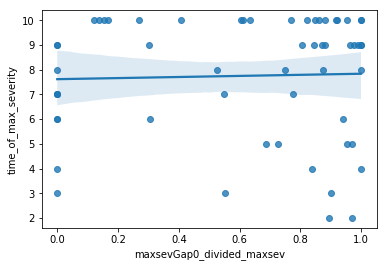

SpearmanrResult(correlation=0.05423059728795105, pvalue=0.6886731952850222) (0.03375396532565306, 0.8031580961167949)


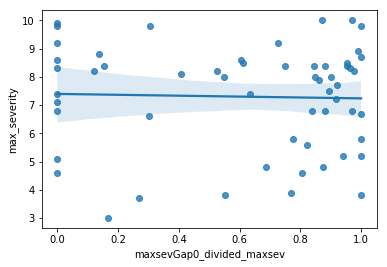

SpearmanrResult(correlation=-0.025854708753275855, pvalue=0.8485991812925615) (-0.032117783262371774, 0.8125226144954076)


In [118]:
for y in ['time_of_max_severity','max_severity']:
    sns.regplot(x='maxsevGap0_divided_maxsev', y=y, data=df_hen);
    plt.show();
    print(spearmanr(df_hen['maxsevGap0_divided_maxsev'].tolist(), df_hen[y].tolist()), 
          pearsonr(df_hen['maxsevGap0_divided_maxsev'].tolist(), df_hen[y].tolist()))

#sns.lmplot(x='time_of_max_severity', y='maxsevGap0_divided_maxsev', x_partial='max_severity', data=df_hen);
#--> not link!! good!!

### maxsevGap0_divided_maxsev link to productivity?

In [119]:
df_hen[df_hen['HenID']=='hen_108']

,HenID,li_severity,li_gap,nbr_nan,AvgSeverity_gap1,AvgSeverity_gap0,AvgSeverity_gap1-AvgSeverity_gap0,maxsevGap0_divided_maxsev,max_severity,positive_rate_in_severity,...,"('Mass', 'tuple')","('Mass', 'nbr')","('Mass', 'variance')","('Mass', 'mean')","('Width', 'tuple')","('Width', 'nbr')","('Width', 'variance')","('Width', 'mean')",hybrid,time_of_max_severity


SpearmanrResult(correlation=-0.11674361748516791, pvalue=0.41944240926556786) (0.03426699054547815, 0.8132425849652136)


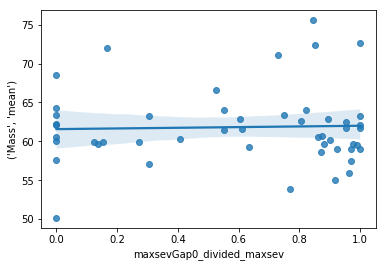

SpearmanrResult(correlation=-0.1390201306399026, pvalue=0.3356260756116315) (-0.06464037165406349, 0.6556098057064632)


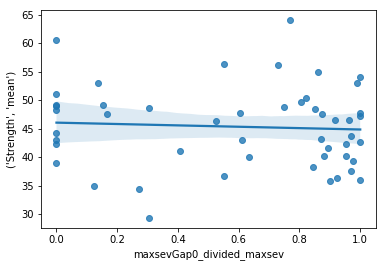

SpearmanrResult(correlation=0.057831609045315875, pvalue=0.6899504150677246) (0.13943541823853428, 0.33417021277138437)


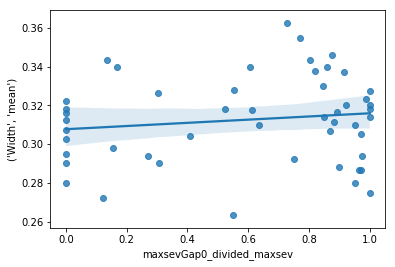

In [120]:
for y in ["('Mass', 'mean')", "('Strength', 'mean')", "('Width', 'mean')"]:
    df_ = df_hen[~df_hen[y].isnull()]
    sns.regplot(x='maxsevGap0_divided_maxsev', y=y, data=df_);
    print(spearmanr(df_['maxsevGap0_divided_maxsev'].tolist(), df_[y].tolist()), 
          pearsonr(df_['maxsevGap0_divided_maxsev'].tolist(), df_[y].tolist()))
    plt.show();
#to bad no link with egg strength!

### max_severity link to productivity?

SpearmanrResult(correlation=0.010957327763003009, pvalue=0.9397989705251966) (0.031258897843957044, 0.8293807856911591)


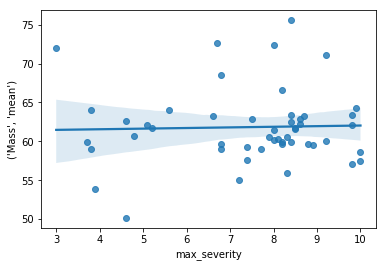

SpearmanrResult(correlation=-0.08831801428703674, pvalue=0.5419274636573892) (-0.22564250156980376, 0.11512414115455628)


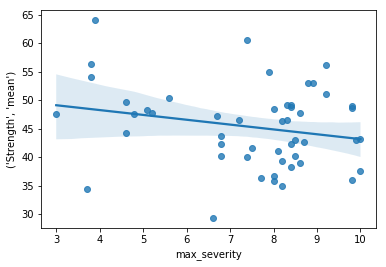

SpearmanrResult(correlation=-0.24657505424246587, pvalue=0.08430886788602591) (-0.2952929149542184, 0.0373516494517515)


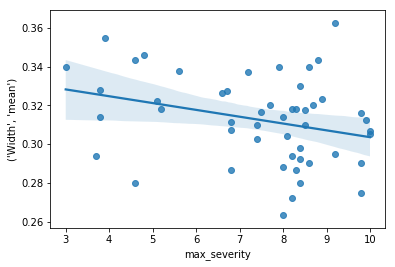

In [121]:
for y in ["('Mass', 'mean')", "('Strength', 'mean')", "('Width', 'mean')"]:
    df_ = df_hen[~df_hen[y].isnull()]
    sns.regplot(x='max_severity', y=y, data=df_);
    print(spearmanr(df_['max_severity'].tolist(), df_[y].tolist()), 
          pearsonr(df_['max_severity'].tolist(), df_[y].tolist()))
    plt.show();
#to bad no link with egg strength!

In [138]:
df_mlp = pd.read_csv(r'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_1A_variables.csv',
                  sep=';', parse_dates=['level','FirstTimestamp_zone_1','FirstTimestamp_zone_2','FirstTimestamp_zone_3',
                                        'FirstTimestamp_zone_4','FirstTimestamp_zone_5'])
df_mlp[(df_mlp['HenID']=='hen_58')] #(df_mlp['level']=='2016-10-31')

,HenID,level,duration_zone_1,duration_zone_2,duration_zone_3,duration_zone_4,duration_zone_5,verification_daily_total_duration,dur_values,dur_values_normalized,...,chatoicmvt_Middlezone_1,chatoicmvt_Middlezone_2,chatoicmvt_Middlezone_3,chatoicmvt_Middlezone_4,chatoicmvt_Middlezone_5,chatoicmvt_Middlezone_1_nbr,chatoicmvt_Middlezone_2_nbr,chatoicmvt_Middlezone_3_nbr,chatoicmvt_Middlezone_4_nbr,chatoicmvt_Middlezone_5_nbr
312,hen_58,2016-10-27,2612.0,1481.0,43741.0,6130.0,36.0,54000.0,"[2612.0, 1481.0, 43741.0, 6130.0, 36.0]","[0.04837037037037037, 0.027425925925925927, 0....",...,0,"[64.0, 25.0, 1010.0]",0,0,0,0,1,0,0,0
313,hen_58,2016-10-28,0.0,769.0,50176.0,3055.0,0.0,54000.0,"[0.0, 769.0, 50176.0, 3055.0, 0.0]","[0.0, 0.014240740740740741, 0.9291851851851852...",...,0,[769.0],0,"[59.0, 15.0]",0,0,1,0,0,0
314,hen_58,2016-10-29,36.0,600.0,44271.0,9093.0,0.0,54000.0,"[36.0, 600.0, 44271.0, 9093.0, 0.0]","[0.0006666666666666666, 0.011111111111111112, ...",...,0,[325.0],0,"[1.0, 61.0, 10.0]",0,0,1,0,0,0
315,hen_58,2016-10-30,0.0,20.0,50943.0,3037.0,0.0,54000.0,"[0.0, 20.0, 50943.0, 3037.0, 0.0]","[0.0, 0.00037037037037037035, 0.94338888888888...",...,0,"[1.0, 19.0]",0,[3037.0],0,0,0,0,1,0
316,hen_58,2016-10-31,0.0,24.0,52104.0,146.0,1726.0,54000.0,"[0.0, 24.0, 52104.0, 146.0, 1726.0]","[0.0, 0.00044444444444444447, 0.96488888888888...",...,0,[6.0],0,0,0,0,0,0,0,0
317,hen_58,2016-11-01,0.0,2230.0,51410.0,360.0,0.0,54000.0,"[0.0, 2230.0, 51410.0, 360.0, 0.0]","[0.0, 0.041296296296296296, 0.952037037037037,...",...,0,[2091.0],0,"[92.0, 42.0]",0,0,1,0,0,0


In [133]:
path_

'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_9B_variables.csv'

In [134]:
li_path

['D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_10A_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_10B_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_11A_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_11B_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_1A_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_1B_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_2A_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_2B_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_3A_variables.csv',
 'D:\\vm_exchange\\AVIFORUM\\data\\extracted_info_mobility_VF\\VF_time_serie_day_3B_variables.cs

In [137]:
df_mlp[(df_mlp['HenID']=='hen_58')] #(df_mlp['level']=='2016-10-31')

,HenID,level,duration_zone_1,duration_zone_2,duration_zone_3,duration_zone_4,duration_zone_5,verification_daily_total_duration,dur_values,dur_values_normalized,...,chatoicmvt_Middlezone_1,chatoicmvt_Middlezone_2,chatoicmvt_Middlezone_3,chatoicmvt_Middlezone_4,chatoicmvt_Middlezone_5,chatoicmvt_Middlezone_1_nbr,chatoicmvt_Middlezone_2_nbr,chatoicmvt_Middlezone_3_nbr,chatoicmvt_Middlezone_4_nbr,chatoicmvt_Middlezone_5_nbr


In [127]:
df_mlp.columns

Index(['FirstTimestamp_zone_1', 'FirstTimestamp_zone_1_h',
       'FirstTimestamp_zone_2', 'FirstTimestamp_zone_2_h',
       'FirstTimestamp_zone_3', 'FirstTimestamp_zone_3_h',
       'FirstTimestamp_zone_4', 'FirstTimestamp_zone_4_h',
       'FirstTimestamp_zone_5', 'FirstTimestamp_zone_5_h', 'HenID',
       'Max_duration_zone_4', 'Max_duration_zones', 'SampEnt_order2',
       'Total_number_transition', 'Total_number_zone',
       'chatoicmvt_Middlezone_1', 'chatoicmvt_Middlezone_1_nbr',
       'chatoicmvt_Middlezone_2', 'chatoicmvt_Middlezone_2_nbr',
       'chatoicmvt_Middlezone_3', 'chatoicmvt_Middlezone_3_nbr',
       'chatoicmvt_Middlezone_4', 'chatoicmvt_Middlezone_4_nbr',
       'chatoicmvt_Middlezone_5', 'chatoicmvt_Middlezone_5_nbr',
       'dico_z_chaoticmvtMiddleDuration', 'dico_zone_sortedduration',
       'distribution_entropy', 'down_missingZone_mvtNbr',
       'down_missingZone_mvtPerc', 'dur_values', 'dur_values_normalized',
       'duration_zone_1', 'duration_zone_2',